# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**План по выполнению проекта**

Провести исследовательский анализ набора фотографий.

Подготовить данные к обучению.

Обучить нейронную сеть и рассчитать её качество.


## Исследовательский анализ данных

Загрузим требуемые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
plt.rcParams["figure.figsize"] = (15,10)

Загрузим выборку

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Выведем размер датасета и гистограмму для возраста людей на фотографиях.

In [ ]:
df.shape

(7591, 2)

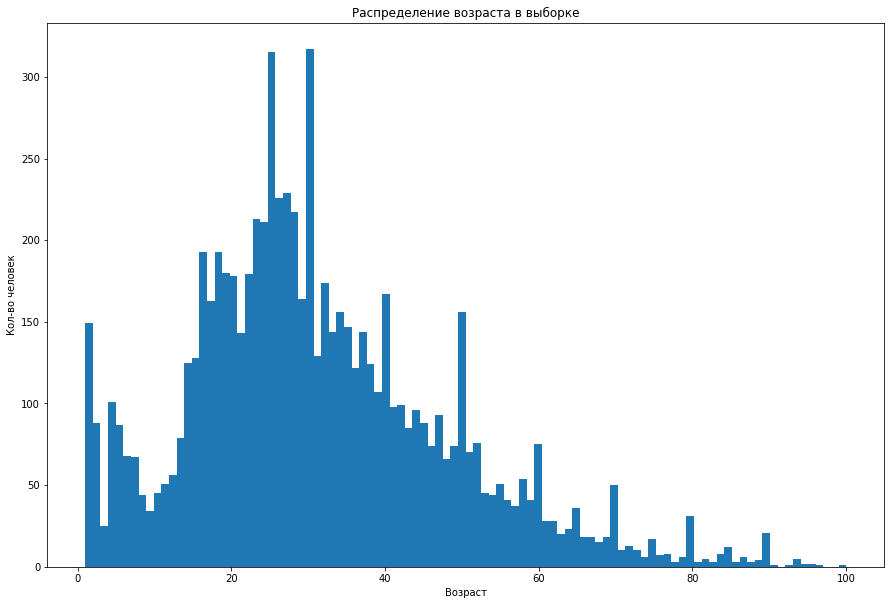

In [ ]:
plt.hist(df.real_age, bins=100)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Кол-во человек');

Выведем статистики для целевого признака

In [ ]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Проверим на пропуски. На дубликаты проверять не требуется, так как возраст у разных людей может совпасть.

In [ ]:
df.isna().sum()

file_name    0
real_age     0
dtype: int64

Пропуски не обнаружены

Напечатаем 15 фото, оценим как устроен датасет.

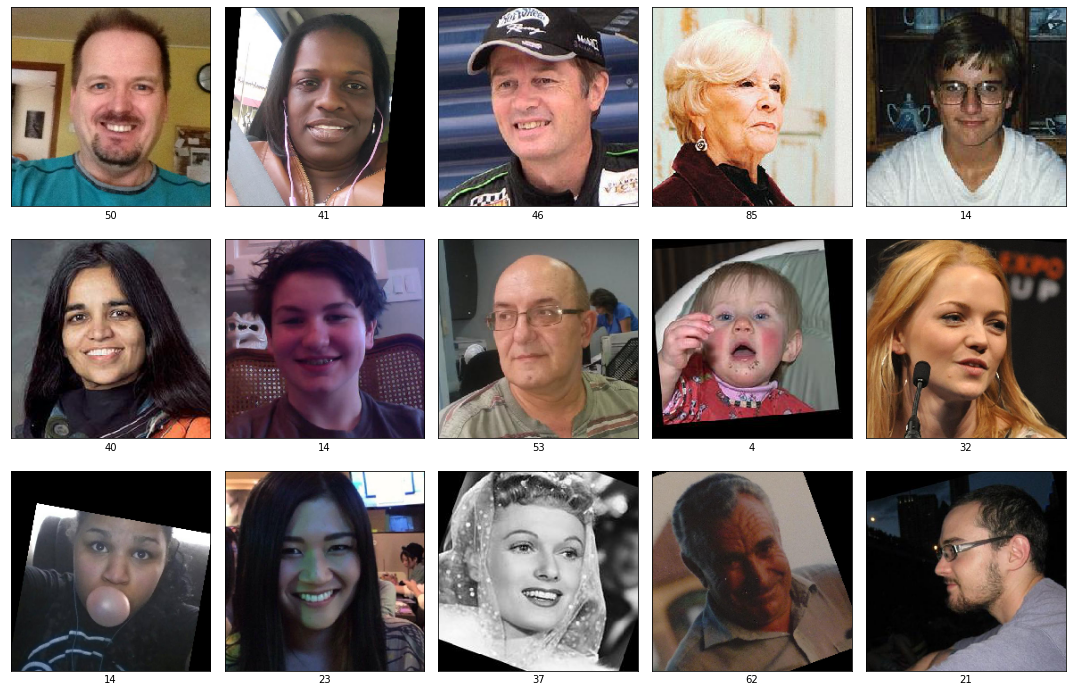

In [ ]:
# Выведем 15 фото
features, target = next(train_gen_flow)

fig = plt.figure()
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

### Вывод

В выборке содержится 7591 фото.

Встречаются фотографии с низким разрешением, где плохо видно лицо человека.

На части изображений лицо человека загорожено посторонними предметами, такими как очки, волосы, головные уборы и т.д.

Часть изображений в черно-белом варианте, часть цветная.

Встречаются фотографии в профиль, где не полностью видно лицо.

Возраст людей имеет диапазон от 1 года до 100 лет.

Средний возраст 31 год, медиана находится на отметке 29 лет.

Большая часть людей на изображениях имеют возраст от 20 до 40 лет.

На обучение модели может оказать влияние низкое разрешение, посторонние предметы и фотографии в профиль.

Считаю целесообразным использовать отражения по горизонтали, а повороты могут не понадобиться, так как фото людей при посещении магазинов будут иметь "макушку" на верху.

Сдвиги изображений по вертикали и горизонтали также считаю не актуальными, так как встречаются фото с широкими полями, и есть риск потерять значимые черты для обучения модели.

## Обучение модели


Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 81s - loss: 201.7480 - mae: 10.3629 - val_loss: 699.4216 - val_mae: 21.4350
Epoch 2/10
356/356 - 45s - loss: 80.9004 - mae: 6.8417 - val_loss: 126.0215 - val_mae: 8.4791
Epoch 3/10
356/356 - 47s - loss: 55.5714 - mae: 5.6930 - val_loss: 79.2995 - val_mae: 6.9494
Epoch 4/10
356/356 - 70s - loss: 44.1780 - mae: 5.0413 - val_loss: 82.0913 - val_mae: 6.6767
Epoch 5/10
356/356 - 59s - loss: 32.4096 - mae: 4.3596 - val_loss: 67.4390 - val_mae: 6.1127
Epoch 6/10
356/356 - 67s - loss: 25.4778 - mae: 3.8620 - val_loss: 106.5597 - val_mae: 7.6512
Epoch 7/10
356/356 - 78s - loss: 21.4681 - mae: 3.5545 - val_loss: 96.5840 - val_mae: 7.7991
Epoch 8/10
356/356 - 66s - loss: 18.6611 - mae: 3.2293 - val_loss: 66.6379 - val_mae: 6.1181
Epoch 9/10
356/356 - 70s - loss: 15.0998 - mae: 2.9793 - val_loss: 88.1132 - val_mae: 7.2774
Epoch 10/10
356/356 - 77s - loss: 12.9688 - mae: 2.7038 - val_loss: 63.3006 - val_mae: 5.9299
119/119 - 12s - loss: 63.3006 - mae: 5.9299
Test MAE: 5.9299

```

## Анализ обученной модели

В проекте использована свёрточная нейронная сеть ResNet50.

Сеть решала задачу регрессии, предсказывая возраст человека по изображению.

Функцией потерь была выбрана MSE.

[В статье о датасете](https://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), с которым мы работали, значение MAE равно 5.4.

Итоговое значение MAE на нашей тестовой выборке составило 5.9, что очень близко к результату статьи.

Из результатов работы модели видно, что MAE на тестовой выборке значительно выше чем на обучающей, это может говорить о возможном переобучении модели. Переобучение происходит, когда ошибка на тестовой выборке постепенно уменьшается, затем становится стабильной на немногих эпохах, а затем начинает увеличиваться. В нашем случае такой эффект заметен уже после пятой эпохи, но на 10 было получено самое низкое значение. Дальнейшее увеличение кол-ва эпох приведет к ухудшению качества и переобучению модели.

Модель призвана решать две задачи бизнеса:

- создание рекомендательной системы для клиентов
- контроль соблюдения правил продаж алкоголя

Средняя абсолютная ошибка с оценкой в 5.9 не является значимой для задачи рекомендаций для большей части покупателей.

Однако считаю, что в группе до 18 лет данная ошибка может существенно повлиять на результат, так как для детского возраста характерна более частая смена предпочтений чем раз в 5.9 лет.

Так же для группы людей пенсионного и предпенсионного возраста система может оказаться менее эффективной, из-за изменения уровня дохода при выходе на пенсию.


Для контроля продаж алкоголя данная ошибка может быть критичной, с одной стороны, однако может существенно сократить расходы на контроль определяя группу риска из покупателей от 12 лет до 24 лет с другой.
